In [5]:
import math
import pyclesperanto_prototype as cle
from pyclesperanto_prototype._tier8._affine_transform import _determine_translation_and_bounding_box
from skimage.io import imread

voxel_size_x_in_microns = 0.1449922
voxel_size_y_in_microns = 0.1449922
voxel_size_z_in_microns = 0.3

deskewing_angle_in_degrees = 30

original_image = imread('../../data/RBC_tiny.tif')
original_image = original_image[::4]
voxel_size_z_in_microns = voxel_size_z_in_microns * 4

#Defining Deskewing
scale_factor = 1 #Scale factor is used in clesperanto if we want to scale the images in case they don't fit in memory

#initialise a transform
deskew_transform =cle.AffineTransform3D()
#Shear
shear_factor = math.sin((90 - deskewing_angle_in_degrees) * math.pi / 180.0) * (voxel_size_z_in_microns/voxel_size_y_in_microns)
deskew_transform._matrix[1, 2] = shear_factor
#Scale
new_dz = math.sin(deskewing_angle_in_degrees * math.pi / 180.0) * voxel_size_z_in_microns
scale_factor_z = (new_dz / voxel_size_y_in_microns) * scale_factor
deskew_transform.scale(scale_x=scale_factor, scale_y=scale_factor, scale_z=scale_factor_z)
#Rotate deskewing angle
deskew_transform.rotate(angle_in_degrees = 0 - deskewing_angle_in_degrees, axis=0)

_,deskew_transform,translation = _determine_translation_and_bounding_box(original_image, deskew_transform)

deskew_transform._matrix


deskewed = cle.affine_transform(source= original_image,transform = deskew_transform,auto_size=True,linear_interpolation=True)
#print(deskewed.shape)

In [6]:
shear_transform =cle.AffineTransform3D()
#Shear
shear_factor = math.sin((90 - deskewing_angle_in_degrees) * math.pi / 180.0) * (voxel_size_z_in_microns/voxel_size_y_in_microns)
shear_transform._matrix[1, 2] = shear_factor

transform_yz1= cle.AffineTransform3D()
transform_yz2= cle.AffineTransform3D()
transform_yz3= cle.AffineTransform3D()
transform_yz4= cle.AffineTransform3D()

#transform_yz1.translate(translate_y=-1,translate_z=-1)
#transform_yz2.translate(translate_y=-1,translate_z=1)
#transform_yz3.translate(translate_y=1,translate_z=-1)
#transform_yz4.translate(translate_y=1,translate_z=1)

transform_yz1.translate(translate_y=0,translate_z=-1)
transform_yz2.translate(translate_y=-1,translate_z=0)
transform_yz3.translate(translate_y=0,translate_z=1)
transform_yz4.translate(translate_y=1,translate_z=0)


In [8]:
import numpy as np 
deskewed_test_affine = cle.affine_transform_deskew(source= original_image,
                                            transform = deskew_transform,
                                             auto_size=True,
                                            shear_transform=shear_transform,
                                            translate_mat_1 = transform_yz1,
                                            translate_mat_2 = transform_yz2,
                                            translate_mat_3 = transform_yz3,
                                            translate_mat_4 = transform_yz4,
                                            linear_interpolation=True)
import napari 
viewer = napari.Viewer() 
deskewed_test_affine = np.asarray(deskewed_test_affine)
viewer.add_image(deskewed_test_affine)

<Image layer 'deskewed_test_affine' at 0x296094b78e0>

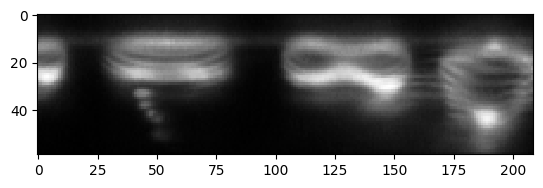

In [22]:
cle.imshow(deskewed_test_affine[:,200])

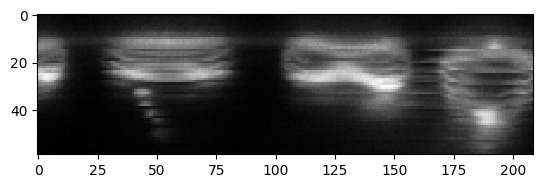

In [35]:
cle.imshow(deskewed_test_affine[:,200])

In [ ]:
virtual_plane = y - z/tantheta
plane_before = floor(virtual_plane/voxel_size_z_in_microns)
plane_after = plane_before+1

l_before = virtual_plane - plane_before * voxel_size_z_in_microns



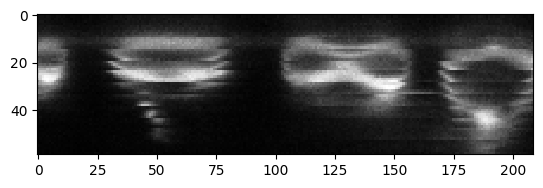

In [32]:
import napari 
viewer = napari.Viewer() 
deskewed = np.asarray(deskewed)
viewer.add_image(deskewed)
cle.imshow(deskewed[:,200])

In [11]:
# Source: https://github.com/QI2lab/OPM/blob/master/reconstruction/image_post_processing.py
# Licensed GPL 3 https://github.com/QI2lab/OPM/blob/master/LICENSE

import sys
import numpy as np
from pathlib import Path
from numba import njit, prange
from functools import partial
import gc


    
# http://numba.pydata.org/numba-doc/latest/user/parallel.html#numba-parallel
@njit(parallel=True)
def deskew(data,theta,distance,pixel_size):
    """
    Perform parallelized orthogonal interpolation into a uniform pixel size grid.
    
    :param data: ndarray
        image stack of uniformly spaced OPM planes
    :param theta: float 
        angle relative to coverslip
    :param distance: float 
        step between image planes along coverslip
    :param pizel_size: float 
        in-plane camera pixel size in OPM coordinates
    :return output: ndarray
        image stack of deskewed OPM planes on uniform grid
    """

    # unwrap parameters 
    [num_images,ny,nx]=data.shape     # (pixels)

    # change step size from physical space (nm) to camera space (pixels)
    pixel_step = distance/pixel_size    # (pixels)

    # calculate the number of pixels scanned during stage scan 
    scan_end = num_images * pixel_step  # (pixels)

    # calculate properties for final image
    final_ny = np.int64(np.ceil(scan_end+ny*np.cos(theta*np.pi/180))) # (pixels)
    final_nz = np.int64(np.ceil(ny*np.sin(theta*np.pi/180)))          # (pixels)
    final_nx = np.int64(nx)                                           # (pixels)

    # create final image
    output = np.zeros((final_nz, final_ny, final_nx),dtype=np.float32)  # (time, pixels,pixels,pixels - data is float32)

    # precalculate trig functions for scan angle
    tantheta = np.float32(np.tan(theta * np.pi/180)) # (float32)
    sintheta = np.float32(np.sin(theta * np.pi/180)) # (float32)
    costheta = np.float32(np.cos(theta * np.pi/180)) # (float32)

    # perform orthogonal interpolation

    # loop through output z planes
    # defined as parallel loop in numba
    # http://numba.pydata.org/numba-doc/latest/user/parallel.html#numba-parallel
    for z in prange(0,final_nz):
        # calculate range of output y pixels to populate
        y_range_min=np.minimum(0,np.int64(np.floor(np.float32(z)/tantheta)))
        y_range_max=np.maximum(final_ny,np.int64(np.ceil(scan_end+np.float32(z)/tantheta+1)))

        # loop through final y pixels
        # defined as parallel loop in numba
        # http://numba.pydata.org/numba-doc/latest/user/parallel.html#numba-parallel
        for y in prange(y_range_min,y_range_max):

            # find the virtual tilted plane that intersects the interpolated plane 
            virtual_plane = y - z/tantheta

            # find raw data planes that surround the virtual plane
            plane_before = np.int64(np.floor(virtual_plane/pixel_step))
            plane_after = np.int64(plane_before+1)

            # continue if raw data planes are within the data range
            if ((plane_before>=0) and (plane_after<num_images)):
                
                # find distance of a point on the  interpolated plane to plane_before and plane_after
                l_before = virtual_plane - plane_before * pixel_step
                l_after = pixel_step - l_before
                
                # determine location of a point along the interpolated plane
                za = z/sintheta
                virtual_pos_before = za + l_before*costheta
                virtual_pos_after = za - l_after*costheta

                # determine nearest data points to interpoloated point in raw data
                pos_before = np.int64(np.floor(virtual_pos_before))
                pos_after = np.int64(np.floor(virtual_pos_after))

                # continue if within data bounds
                if ((pos_before>=0) and (pos_after >= 0) and (pos_before<ny-1) and (pos_after<ny-1)):
                    
                    # determine points surrounding interpolated point on the virtual plane 
                    dz_before = virtual_pos_before - pos_before
                    dz_after = virtual_pos_after - pos_after

                    # compute final image plane using orthogonal interpolation
                    output[z,y,:] = (l_before * dz_after * data[plane_after,pos_after+1,:] +
                                    l_before * (1-dz_after) * data[plane_after,pos_after,:] +
                                    l_after * dz_before * data[plane_before,pos_before+1,:] +
                                    l_after * (1-dz_before) * data[plane_before,pos_before,:]) /pixel_step


    return output


deskewed_opm = deskew(original_image,deskewing_angle_in_degrees,voxel_size_z_in_microns,voxel_size_x_in_microns)


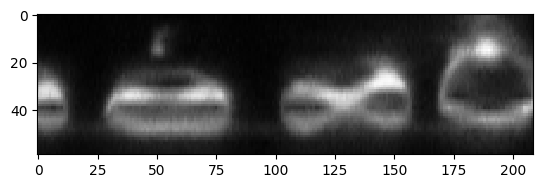

In [12]:
cle.imshow(deskewed_opm[:,200])

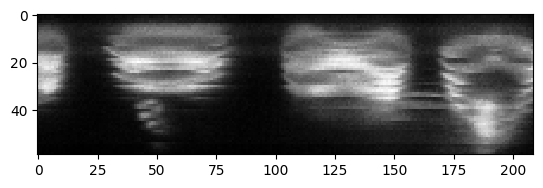

In [13]:
cle.imshow(deskewed_test_affine[:,200])